In [7]:
import csv
import os
import pandas as pd
import torch
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from time import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [8]:
def create_csv(root_folder, output_csv):
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_filename', 'label'])

        for label in os.listdir(root_folder):
            label_path = os.path.join(root_folder, label)
            if os.path.isdir(label_path):
                for image_filename in os.listdir(label_path):
                    image_path = os.path.join(label, image_filename)
                    label_value = int(label)
                    writer.writerow([image_path, label_value])

# Specify the path to your "Train" and "Test" dataset folders
train_dataset_folder = 'Train/'
test_dataset_folder = 'Test/'
validation_dataset_folder = "Validation/"

# Create the CSV files
create_csv(train_dataset_folder, "Train/train.csv")
create_csv(test_dataset_folder, "Test/test.csv")
create_csv(validation_dataset_folder, "Validation/validation.csv")

print('CSV files created.')

CSV files created.


In [9]:
class AIDER(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # Use PIL to open and transform the image
        image = Image.open(img_path).convert('RGB')

        label = int(self.img_labels.iloc[idx, 1])  # Convert label to integer
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Convert label to torch.LongTensor
        label = torch.LongTensor([label])
        return image, label

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 5)

Using cache found in C:\Users\최신우/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.

In [11]:
training_data = AIDER(
    annotations_file="Train/train.csv",
    img_dir="Train/",
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
    ])
)

test_data = AIDER(
    annotations_file="Test/test.csv",
    img_dir="Test/",
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
    ])
)

validation_data = AIDER(
    annotations_file="Validation/validation.csv",
    img_dir="Validation/",
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
    ])
)



train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False, pin_memory=True)

In [12]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Switching to CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
best_val_loss = float('inf')  # Initialize with a large value

def train(model, train_loader, optimizer, criterion, num_epochs):
    global best_val_loss
    patience = 10  # Number of epochs to wait for improvement
    counter = 0  # Counter to track epochs without improvement
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        initial_time = time()
        progress_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        for i, (inputs, labels) in progress_bar:
            optimizer.zero_grad()
            # Move inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, *_ = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            progress_bar.set_postfix({'Epoch': epoch+1, 'Loss': running_loss / i})
        
        
        print(f"Epoch {epoch+1} finished. Took {time() - initial_time:.2f}s.")
        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(validation_loader, 1):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                val_loss += loss.item()
    
                _, predicted = torch.max(outputs.data, 1)
                labels = labels.flatten()
                predicted = predicted.flatten()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(validation_loader)
        accuracy_val = correct_val / total_val
        print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * accuracy_val:.2f}%')
        
        scheduler.step(avg_val_loss)

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f'Early stopping after {epoch+1} epochs without improvement.')
            break
            
num_epochs = 1000
train(model, train_loader, optimizer, criterion, num_epochs)

C:\Users\최신우\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


GPU is available.


100%|██████████| 114/114 [00:39<00:00,  2.88it/s, Epoch=1, Loss=1.17]


Epoch 1 finished. Took 39.61s.
Validation Loss: 1.3685394704341889, Validation Accuracy: 41.00%


100%|██████████| 114/114 [00:37<00:00,  3.01it/s, Epoch=2, Loss=1.1] 


Epoch 2 finished. Took 37.87s.
Validation Loss: 1.4473367631435394, Validation Accuracy: 42.33%


100%|██████████| 114/114 [00:40<00:00,  2.79it/s, Epoch=3, Loss=1.05]


Epoch 3 finished. Took 40.85s.
Validation Loss: 1.2804309666156768, Validation Accuracy: 40.00%


100%|██████████| 114/114 [00:39<00:00,  2.89it/s, Epoch=4, Loss=0.996]


Epoch 4 finished. Took 39.51s.
Validation Loss: 1.5023435205221176, Validation Accuracy: 41.33%


100%|██████████| 114/114 [00:39<00:00,  2.91it/s, Epoch=5, Loss=0.963]


Epoch 5 finished. Took 39.15s.
Validation Loss: 2.457615403831005, Validation Accuracy: 33.33%


100%|██████████| 114/114 [00:38<00:00,  2.96it/s, Epoch=6, Loss=0.941]


Epoch 6 finished. Took 38.55s.
Validation Loss: 1.3546169847249985, Validation Accuracy: 43.67%


100%|██████████| 114/114 [00:38<00:00,  2.95it/s, Epoch=7, Loss=0.934]


Epoch 7 finished. Took 38.70s.
Validation Loss: 1.5949870735406875, Validation Accuracy: 38.33%


100%|██████████| 114/114 [00:39<00:00,  2.88it/s, Epoch=8, Loss=0.921]


Epoch 8 finished. Took 39.54s.
Validation Loss: 1.1265168488025665, Validation Accuracy: 53.33%


100%|██████████| 114/114 [00:39<00:00,  2.92it/s, Epoch=9, Loss=0.883]


Epoch 9 finished. Took 39.08s.
Validation Loss: 1.107254073023796, Validation Accuracy: 55.00%


100%|██████████| 114/114 [00:39<00:00,  2.92it/s, Epoch=10, Loss=0.883]


Epoch 10 finished. Took 39.05s.
Validation Loss: 1.0224508672952652, Validation Accuracy: 53.67%


100%|██████████| 114/114 [00:40<00:00,  2.84it/s, Epoch=11, Loss=0.881]


Epoch 11 finished. Took 40.16s.
Validation Loss: 1.1649601593613625, Validation Accuracy: 49.67%


100%|██████████| 114/114 [00:39<00:00,  2.89it/s, Epoch=12, Loss=0.839]


Epoch 12 finished. Took 39.45s.
Validation Loss: 1.6116022273898125, Validation Accuracy: 47.67%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=13, Loss=0.834]


Epoch 13 finished. Took 38.35s.
Validation Loss: 1.6086828693747521, Validation Accuracy: 48.67%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=14, Loss=0.822]


Epoch 14 finished. Took 38.19s.
Validation Loss: 1.0499308824539184, Validation Accuracy: 58.00%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=15, Loss=0.812]


Epoch 15 finished. Took 38.16s.
Validation Loss: 0.9844160735607147, Validation Accuracy: 57.33%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=16, Loss=0.794]


Epoch 16 finished. Took 38.14s.
Validation Loss: 2.2198938466608524, Validation Accuracy: 34.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=17, Loss=0.771]


Epoch 17 finished. Took 38.22s.
Validation Loss: 0.8126440733671189, Validation Accuracy: 69.33%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=18, Loss=0.772]


Epoch 18 finished. Took 38.25s.
Validation Loss: 1.0093697309494019, Validation Accuracy: 59.33%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=19, Loss=0.755]


Epoch 19 finished. Took 38.44s.
Validation Loss: 1.6362508043646813, Validation Accuracy: 45.67%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=20, Loss=0.77] 


Epoch 20 finished. Took 38.39s.
Validation Loss: 0.7634054094552993, Validation Accuracy: 66.67%


100%|██████████| 114/114 [00:38<00:00,  3.00it/s, Epoch=21, Loss=0.751]


Epoch 21 finished. Took 38.05s.
Validation Loss: 1.2253301113843917, Validation Accuracy: 54.67%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=22, Loss=0.739]


Epoch 22 finished. Took 38.42s.
Validation Loss: 1.9421815171837806, Validation Accuracy: 39.33%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=23, Loss=0.725]


Epoch 23 finished. Took 38.19s.
Validation Loss: 0.7381871044635773, Validation Accuracy: 70.33%


100%|██████████| 114/114 [00:40<00:00,  2.81it/s, Epoch=24, Loss=0.723]


Epoch 24 finished. Took 40.64s.
Validation Loss: 0.9787269473075867, Validation Accuracy: 63.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=25, Loss=0.705]


Epoch 25 finished. Took 38.40s.
Validation Loss: 1.0001967057585717, Validation Accuracy: 61.00%


100%|██████████| 114/114 [00:38<00:00,  2.93it/s, Epoch=26, Loss=0.702]


Epoch 26 finished. Took 38.97s.
Validation Loss: 1.6601491041481495, Validation Accuracy: 44.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=27, Loss=0.709]


Epoch 27 finished. Took 38.27s.
Validation Loss: 0.8329059600830078, Validation Accuracy: 67.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=28, Loss=0.694]


Epoch 28 finished. Took 38.39s.
Validation Loss: 0.736777663230896, Validation Accuracy: 70.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=29, Loss=0.674]


Epoch 29 finished. Took 38.28s.
Validation Loss: 0.9041874051094055, Validation Accuracy: 61.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=30, Loss=0.703]


Epoch 30 finished. Took 38.27s.
Validation Loss: 0.712952795624733, Validation Accuracy: 74.00%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=31, Loss=0.67] 


Epoch 31 finished. Took 38.23s.
Validation Loss: 0.9915824055671691, Validation Accuracy: 64.33%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=32, Loss=0.677]


Epoch 32 finished. Took 38.38s.
Validation Loss: 0.7934791393578052, Validation Accuracy: 66.33%


100%|██████████| 114/114 [00:38<00:00,  2.96it/s, Epoch=33, Loss=0.678]


Epoch 33 finished. Took 38.54s.
Validation Loss: 1.3902435906231403, Validation Accuracy: 50.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=34, Loss=0.632]


Epoch 34 finished. Took 38.31s.
Validation Loss: 0.984803007543087, Validation Accuracy: 59.67%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=35, Loss=0.649]


Epoch 35 finished. Took 38.32s.
Validation Loss: 0.5703078061342239, Validation Accuracy: 79.33%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=36, Loss=0.641]


Epoch 36 finished. Took 38.29s.
Validation Loss: 1.013572570681572, Validation Accuracy: 60.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=37, Loss=0.644]


Epoch 37 finished. Took 38.38s.
Validation Loss: 0.7066848009824753, Validation Accuracy: 74.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=38, Loss=0.626]


Epoch 38 finished. Took 38.36s.
Validation Loss: 0.7048078760504722, Validation Accuracy: 72.00%


100%|██████████| 114/114 [00:38<00:00,  2.96it/s, Epoch=39, Loss=0.642]


Epoch 39 finished. Took 38.53s.
Validation Loss: 0.9685895681381226, Validation Accuracy: 62.33%


100%|██████████| 114/114 [00:38<00:00,  2.96it/s, Epoch=40, Loss=0.627]


Epoch 40 finished. Took 38.51s.
Validation Loss: 2.1458848025649786, Validation Accuracy: 39.33%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=41, Loss=0.619]


Epoch 41 finished. Took 38.28s.
Validation Loss: 1.5353623293340206, Validation Accuracy: 52.67%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=42, Loss=0.561]


Epoch 42 finished. Took 38.35s.
Validation Loss: 0.4959984511137009, Validation Accuracy: 82.00%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=43, Loss=0.537]


Epoch 43 finished. Took 38.30s.
Validation Loss: 0.532388512790203, Validation Accuracy: 78.67%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=44, Loss=0.536]


Epoch 44 finished. Took 38.18s.
Validation Loss: 0.4698755443096161, Validation Accuracy: 82.33%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=45, Loss=0.529]


Epoch 45 finished. Took 38.32s.
Validation Loss: 0.4764758124947548, Validation Accuracy: 81.33%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=46, Loss=0.504]


Epoch 46 finished. Took 38.36s.
Validation Loss: 0.5786920875310898, Validation Accuracy: 77.67%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=47, Loss=0.504]


Epoch 47 finished. Took 38.32s.
Validation Loss: 0.5219560623168945, Validation Accuracy: 79.67%


100%|██████████| 114/114 [00:38<00:00,  2.99it/s, Epoch=48, Loss=0.514]


Epoch 48 finished. Took 38.07s.
Validation Loss: 0.5310091882944107, Validation Accuracy: 79.33%


100%|██████████| 114/114 [00:38<00:00,  2.95it/s, Epoch=49, Loss=0.49] 


Epoch 49 finished. Took 38.62s.
Validation Loss: 0.46072949320077894, Validation Accuracy: 81.00%


100%|██████████| 114/114 [00:38<00:00,  2.98it/s, Epoch=50, Loss=0.508]


Epoch 50 finished. Took 38.25s.
Validation Loss: 0.5406258679926396, Validation Accuracy: 77.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=51, Loss=0.504]


Epoch 51 finished. Took 38.38s.
Validation Loss: 0.5377642527222634, Validation Accuracy: 79.00%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=52, Loss=0.511]


Epoch 52 finished. Took 38.44s.
Validation Loss: 0.5449214339256286, Validation Accuracy: 80.33%


100%|██████████| 114/114 [00:38<00:00,  2.97it/s, Epoch=53, Loss=0.492]


Epoch 53 finished. Took 38.39s.
Validation Loss: 0.44641302675008776, Validation Accuracy: 80.33%


100%|██████████| 114/114 [00:37<00:00,  3.00it/s, Epoch=54, Loss=0.501]


Epoch 54 finished. Took 37.97s.
Validation Loss: 0.4762830018997192, Validation Accuracy: 81.00%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=55, Loss=0.463]


Epoch 55 finished. Took 38.77s.
Validation Loss: 0.4296741262078285, Validation Accuracy: 84.00%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=56, Loss=0.503]


Epoch 56 finished. Took 38.73s.
Validation Loss: 0.54638791680336, Validation Accuracy: 80.33%


100%|██████████| 114/114 [00:38<00:00,  2.95it/s, Epoch=57, Loss=0.459]


Epoch 57 finished. Took 38.70s.
Validation Loss: 0.4428883597254753, Validation Accuracy: 84.00%


100%|██████████| 114/114 [00:38<00:00,  2.95it/s, Epoch=58, Loss=0.477]


Epoch 58 finished. Took 38.68s.
Validation Loss: 0.43671863749623296, Validation Accuracy: 84.00%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=59, Loss=0.472]


Epoch 59 finished. Took 38.79s.
Validation Loss: 0.46965655982494353, Validation Accuracy: 80.67%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=60, Loss=0.468]


Epoch 60 finished. Took 38.82s.
Validation Loss: 0.45107143372297287, Validation Accuracy: 82.00%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=61, Loss=0.483]


Epoch 61 finished. Took 38.74s.
Validation Loss: 0.4552366241812706, Validation Accuracy: 82.67%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=62, Loss=0.453]


Epoch 62 finished. Took 38.72s.
Validation Loss: 0.48829553797841074, Validation Accuracy: 79.67%


100%|██████████| 114/114 [00:38<00:00,  2.94it/s, Epoch=63, Loss=0.45] 


Epoch 63 finished. Took 38.80s.
Validation Loss: 0.43703887313604356, Validation Accuracy: 83.33%


100%|██████████| 114/114 [00:38<00:00,  2.92it/s, Epoch=64, Loss=0.467]


Epoch 64 finished. Took 39.00s.
Validation Loss: 0.45575846955180166, Validation Accuracy: 83.00%


100%|██████████| 114/114 [00:38<00:00,  2.95it/s, Epoch=65, Loss=0.454]


Epoch 65 finished. Took 38.60s.
Validation Loss: 0.46330613642930984, Validation Accuracy: 82.33%
Early stopping after 65 epochs without improvement.


In [13]:
# Evaluate the model on the test set
model.eval()
predicted_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        correct = 0
        total = 0
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        labels = labels.flatten()
        predicted = predicted.flatten()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())
        accuracy = correct / total
        print(f'Batch {i+1} Accuracy: {100 * accuracy:.2f}%')

Batch 1 Accuracy: 93.75%
Batch 2 Accuracy: 96.88%
Batch 3 Accuracy: 100.00%
Batch 4 Accuracy: 81.25%
Batch 5 Accuracy: 81.25%
Batch 6 Accuracy: 62.50%
Batch 7 Accuracy: 87.50%
Batch 8 Accuracy: 81.25%
Batch 9 Accuracy: 78.12%
Batch 10 Accuracy: 71.88%
Batch 11 Accuracy: 37.50%
Batch 12 Accuracy: 31.25%
Batch 13 Accuracy: 68.75%
Batch 14 Accuracy: 65.62%
Batch 15 Accuracy: 84.38%
Batch 16 Accuracy: 81.25%


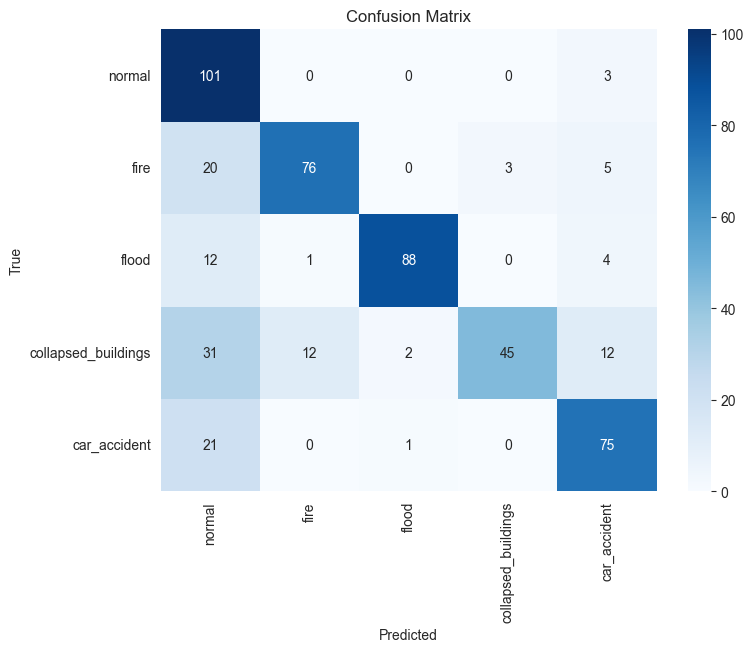

In [14]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Convert class names to indices for plotting
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_mapping = {0: 'normal', 1: 'fire', 2: 'flood', 3: 'collapsed_buildings', 4: 'car_accident'}

predicted_labels = np.array(predicted_labels)
true_labels = [class_mapping[label] for label in test_data.img_labels['label']]
true_labels = np.array([list(class_mapping.keys())[list(class_mapping.values()).index(label)] for label in true_labels])
# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_mapping.values())